## Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

Implementación del algoritmo Grad-CAM para visualizar zonas de activición de una red convolucional con PyTorch.

**Autor:**  M. en C. Mario Xavier Canche Uc, Septiembre 2020, *mario.canche@cimat.mx*  
**Basado en:** https://arxiv.org/pdf/1610.02391.pdf, https://arxiv.org/pdf/1610.02391v1.pdf  

**Material de referencia:**
- http://gradcam.cloudcv.org
- https://github.com/ramprs/grad-cam
- https://www.cimat.mx/~mrivera/cursos/aprendizaje_profundo/GradCAM/GradCAM.html

![Arquitectura de la red](http://gradcam.cloudcv.org/static/images/network.png)

## Cargamos las librerias

In [1]:
# Manipulación de arrays
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de imagenes
from PIL import Image
import cv2

# Conexion a la web
import requests
from urllib.request import urlopen

# PyTorch
import torch
from torch.autograd import Function
from torchvision import models, transforms

In [2]:
# Verificamos si tenemos GPU's disponibles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definimos el Algoritmo

In [3]:
class GradCAM():
    """
    Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
    """ 
    def __init__(self, model, device):   
        super(GradCAM, self).__init__()
        self.model = model
        self.gradients = []
        self.device = device
        
    def save_gradient(self, grad):
        self.gradients.append(grad)
        
    def get_gradient(self):
        return(self.gradients)
        
    def make_gradcam(self, x, feature_module, target_layer_names):
        # Recorremos y procesamos las capas anteriores
        for name, module in model._modules.items():
            if module == feature_module:
                # Recorremos los elementos del layer
                target_activations = []
                self.gradients = []
                for sub_name, sub_module in module._modules.items():
                    x = sub_module(x)
                    if sub_name in target_layer_names:
                        x.register_hook(self.save_gradient)
                        target_activations += [x]

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
                
        self.output = x
        self.features = target_activations
        
        return(target_activations, x)
    
    def get_heatmap(self, index, img_array, feature_module, ):
        # Creamos el vector one-hot de etiquetas
        one_hot = np.zeros((1, self.output.size()[-1]), dtype=np.float32)
        # Asignamos valor al indice de la clase seleccionada
        one_hot[0][index] = 1
        # Convertimos a tensor y agregamos bandera de tensor con gradiente
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        # Filtramos al valor de salida de la clase seleccionada
        one_hot = torch.sum(one_hot.to(self.device) * self.output)

        # clears old gradients from the last step
        feature_module.zero_grad()
        self.model.zero_grad()
        # Aplicamos backpropagation
        one_hot.backward(retain_graph=True)

        # Obtenemos le gradiente
        grads_val = self.get_gradient()[-1].cpu().data.numpy()

        # Vector de pesos: medias del gradiente por capas
        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        
        # salida de la última capa convolucional
        target = self.features[-1].cpu().data.numpy()[0, :]
        
        # saliencia es la respuesta promedio de la última capa convolucional
        saliency = np.mean(target, axis=0)
        saliency = np.maximum(saliency, 0)
        saliency = cv2.resize(saliency, images.shape[2:])
        saliency = saliency - np.min(saliency)
        saliency = saliency / np.max(saliency)

        # Multiplicación de cada canal por el vector de pesos
        grad_cam = np.zeros(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam += w * target[i, :, :]

        # Truncamos la cota inferior a cero
        grad_cam = np.maximum(grad_cam, 0)
        # Redimensionamos el mapa
        grad_cam = cv2.resize(grad_cam, images.shape[2:])
        # Normalizamos los valores del mapa
        grad_cam = grad_cam - np.min(grad_cam)
        grad_cam = grad_cam / np.max(grad_cam)
        
        # Combinamos el mapa con la imagen de entrada
        heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        img_cam = heatmap + img_array
        img_cam = img_cam / np.max(img_cam)
        img_cam = cv2.cvtColor(img_cam,cv2.COLOR_RGB2BGR)
        
        return(grad_cam, img_cam, saliency)

## Cargamos los datos a procesar

In [4]:
# Definimos los parametros para las imagenes
scale = 255
img_size = (224,224)

In [5]:
# Descargamos la imagen a procesar
#url = 'https://s3fs.bestfriends.org/s3fs-public/Introduce-cat-dog-Cappuccino-6654sak.jpg'
url = 'https://github.com/jacobgil/pytorch-grad-cam/blob/master/examples/both.png?raw=true'

#url = 'http://gradcam.cloudcv.org/media/grad_cam/demo_captioning/COCO_val2014_000000125524.jpg'
#url = 'http://gradcam.cloudcv.org/media/grad_cam/demo_captioning/COCO_val2014_000000396387.jpg'
#url = 'http://gradcam.cloudcv.org/media/grad_cam/demo_captioning/COCO_val2014_000000008401.jpg'
#url = 'http://gradcam.cloudcv.org/media/grad_cam/demo_captioning/COCO_val2014_000000096638.jpg'
#url = 'http://gradcam.cloudcv.org/media/coco/val2014/COCO_val2014_000000193481.jpg'
#url = 'http://gradcam.cloudcv.org/media/coco/val2014/COCO_val2014_000000154000.jpg'
#url = 'http://gradcam.cloudcv.org/media/coco/val2014/COCO_val2014_000000001228.jpg'


archivo_src = urlopen(url)

print("Imagen a procesar: ", archivo_src)

Imagen a procesar:  <http.client.HTTPResponse object at 0x7fb98cb2c208>


In [6]:
# Descargamos los label's de Imagenet
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

In [7]:
# Pre-procesamos la imagen
img = Image.open(archivo_src).resize(size=img_size[:2])
img_array = np.array(img).astype('float32')[:,:,:3]/scale

# Convertimos a tensor de PyTorch
image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])(img)
image = image.to(device) # Cargamos a GPU o CPU
images = torch.stack([image])

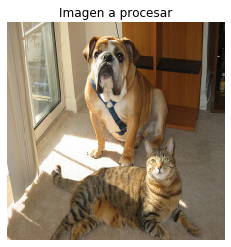

In [8]:
# Visualizamos los datos
plt.imshow(img)
plt.axis('off')
plt.title("Imagen a procesar")
plt.show()

## Ejecutamos el Algoritmo

In [9]:
# Cargamos el modelo pre-entrenado
#model = models.vgg16(pretrained=True)
model = models.resnet50(pretrained=True)
model.to(device)
model.eval();

# Nombre de los layers en el Modelo
print("Layers: ", list(model._modules.keys()))
# Nombre de las unidades del layer
print("Unidades del Layer: ", list(model.layer4._modules.keys()))

Layers:  ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
Unidades del Layer:  ['0', '1', '2']


In [10]:
# Definimos los parametros del modelo
feature_module = model.layer4
target_layer_names = ["2"]

# Indice de la mejor prediccion
index = 0

In [11]:
# Ejecutamos el algoritmo GradCAM
gc = GradCAM(model, device)
_, preds = gc.make_gradcam(images,feature_module, target_layer_names)

In [12]:
# Ordenamos las predicciones y nos quedamos con las 5 mejores
max_index = preds.cpu().data.numpy().argsort()[0][::-1][:5]
# Imprimimos las clases posibles
print("Clases más probables según el modelo seleccionado:")
for i in max_index:
    print("  ", i," --> ",labels[i])

Clases más probables según el modelo seleccionado:
   243  -->  bull mastiff
   282  -->  tiger cat
   242  -->  boxer
   281  -->  tabby, tabby cat
   539  -->  doormat, welcome mat


In [13]:
# Construimos el mapa de GradCAM
grad_cam, img_cam, saliency = gc.get_heatmap(max_index[index], img_array, feature_module)

## Visualizamos los resultados

** Grad-CAM para la clase 243 :  0 -> bull mastiff


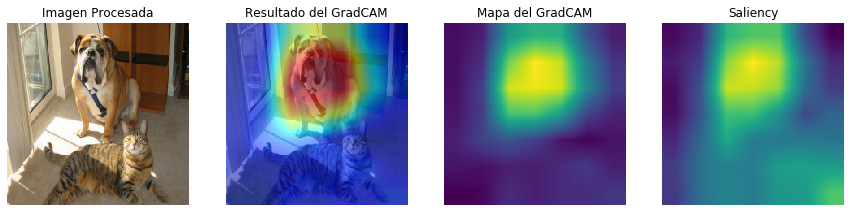

In [14]:
# Visualizamos y comparamos los resultados del GradCAM
print("** Grad-CAM para la clase", max_index[index],": ", index, "->", labels[max_index[index]])
plt.figure(figsize=(15, 10))

plt.subplot(141)
plt.imshow(img)
plt.title("Imagen Procesada")
plt.axis('off')

plt.subplot(142)
plt.imshow(img_cam)
plt.title("Resultado del GradCAM")
plt.axis('off')

plt.subplot(143)
plt.imshow(grad_cam)
plt.title("Mapa del GradCAM")
plt.axis('off')

plt.subplot(144)
plt.imshow(saliency)
plt.title("Saliency")
plt.axis('off')

plt.show()